In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jcartus/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Prepare Dataset 

In [3]:
data_path = "../../dataset/400"
postfix = "400"

dim = 26

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))

In [4]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset

BATCH_SIZE = 32

s_triu = extract_triu_batch(S, dim)
p_triu = extract_triu_batch(P, dim)

s_triu_norm, mu, std = AbstractDataset.normalize(s_triu)

#dataset = tf.data.Dataset.from_tensor_slices((s_triu_norm, p_triu))
#dataset.batch(BATCH_SIZE).repeat()

data= (s_triu_norm, p_triu)

#ind_validation = int(np.ceil(0.8 * len(S)))
#train = (s_triu_norm[:ind_validation], p_triu[:ind_validation])
#validation = (s_triu_norm[ind_validation:], p_triu[ind_validation:])

#train.batch(BATCH_SIZE).repeat()
#validation.batch(BATCH_SIZE).repeat()




# Test Utilities 

In [91]:
def build_model(activation, n_layers, learning_rate=1e-4):
    initializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)
    
    model = keras.Sequential()
    
    # input layer
    model.add(keras.layers.Dense(
        dim_triu, 
        activation=activation, 
        input_dim=dim_triu,
        kernel_initializer=initializer, 
        #bias_initializer='zeros',
    ))
    
    # hidden layers
    for i in range(n_layers):
        model.add(keras.layers.Dense(
            dim_triu, 
            activation,
            kernel_initializer=initializer, 
        ))
    
    #output
    model.add(keras.layers.Dense(
        dim_triu,
        kernel_initializer=initializer, 
    ))
    
    model.compile(optimizer=tf.train.AdamOptimizer(learning_rate), loss='MSE', metrics=['mae', 'mse'])
    
    return model

In [98]:
N_TESTS = 5
EPOCHS = 10000

early_stopping = keras.callbacks.EarlyStopping(monitor="val_mean_squared_error", min_delta=1e-10, patience=5)

def test_model(n_layers, activation, n_tests=N_TESTS, epochs=EPOCHS, learning_rate=1e-4):
    error = []
    
    for i in range(n_tests):
        keras.backend.clear_session()
        model = build_model(activation, layer, learning_rate)
        history = model.fit(data[0], data[1], epochs=epochs, validation_split=0.2, verbose=0, callbacks=[early_stopping])
        
        error.append(np.min(history.history["val_mean_absolute_error"]))
        
        print(" - Test " + str(i+1) + ": " + str(error[-1]))
    
    return error

def run_layer_test_series(activation, layers, learning_rate):
    error = []
    for layer in layers:
        print("Layers: " + str(layer))
        error.append(test_model(layer, activation, learning_rate=learning_rate))
    return error

# Testing 

In [101]:
layers = [2, 3, 4, 6, 10]
learning_rates = [1e-3, 1e-4, 1e-5]

In [102]:
res = []
for lr in learning_rates:
    print("# lr" + str(lr))
    res.append(run_layer_test_series('elu', layers, lr))

# lr0.001
Layers: 2
 - Test 1: 0.03917955647199607
 - Test 2: 0.03664106512365262
 - Test 3: 0.03918226792915794
 - Test 4: 0.02795815156880489
 - Test 5: 0.03831909710833849
Layers: 3
 - Test 1: 0.03956884308910567
 - Test 2: 0.034777032873354666
 - Test 3: 0.031135836600764723
 - Test 4: 0.02837332609024915
 - Test 5: 0.03408684920180927
# lr0.0001
Layers: 2
 - Test 1: 0.12126924781021008
 - Test 2: 0.12314820043311632
 - Test 3: 0.12000379101796584
 - Test 4: 0.1223202926560867
 - Test 5: 0.12112834064428471
Layers: 3
 - Test 1: 0.12321732925974634
 - Test 2: 0.1179753709430537
 - Test 3: 0.12115989311421213
 - Test 4: 0.11912330375476317
 - Test 5: 0.11986900096343568


In [103]:
x = np.array([layer for layer in layers for i in range(N_TESTS)])

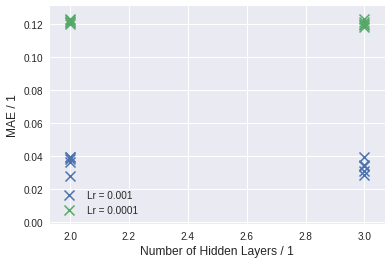

In [105]:
for r, lr in zip(res, learning_rates):
    plt.scatter(x, np.array(r).flatten(), marker="x", label="Lr = " + str(lr) )

plt.xlabel("Number of Hidden Layers / 1")
plt.ylabel("MAE / 1")

plt.legend()

plt.show()

In [64]:
(5e-3)**2

2.5e-05